#  Reduced particle densities

## One-particle density
The one-particle density can be written as an expectation of a one-electron operator according to

$$
n(\mathbf{r}) =
\langle \Psi | \hat{n}(\mathbf{r}) | \Psi \rangle
$$

with

$$
\hat{n}(\mathbf{r}) = 
\sum_{i=1}^N
\delta(\mathbf{r} - \mathbf{r}_i)
$$

For an $N$-electron system in a state described by a Slater determinant, the one-electron density becomes

$$
n(\mathbf{r}) = \sum_{i=1}^N |\psi_i(\mathbf{r})|^2
$$

where the summation run over the $N$ occupied spin orbitals.

In [1]:
import veloxchem as vlx
import matplotlib.pyplot as plt
import numpy as np

* Warning * Environment variable OMP_NUM_THREADS not set.
* Warning * Setting OMP_NUM_THREADS to 8.


In [2]:
mol_str = """
C        0.00000000    0.00000000    0.00000000
O        0.00000000    0.00000000    1.43
"""
molecule = vlx.Molecule.read_str(mol_str, units='angstrom')
basis = vlx.MolecularBasis.read(molecule, '6-31g')

scf_drv = vlx.ScfRestrictedDriver()
scf_drv.compute(molecule, basis)

density = scf_drv.density

                                                                                                                          
                                            Self Consistent Field Driver Setup                                            
                                                                                                                          
                   Wave Function Model             : Spin-Restricted Hartree-Fock                                         
                   Initial Guess Model             : Superposition of Atomic Densities                                    
                   Convergence Accelerator         : Two Level Direct Inversion of Iterative Subspace                     
                   Max. Number of Iterations       : 50                                                                   
                   Max. Number of Error Vectors    : 10                                                                   
                

In [12]:
vis_drv = vlx.VisualizationDriver()

# list of coordinates in units of Bohr
n = 100
coords = np.zeros((n,3))
z = np.linspace(-1,4,n)
coords[:,2] = z

mo = 0
one_part_den = vis_drv.get_density(coords, molecule, basis, density, mo, 'alpha')

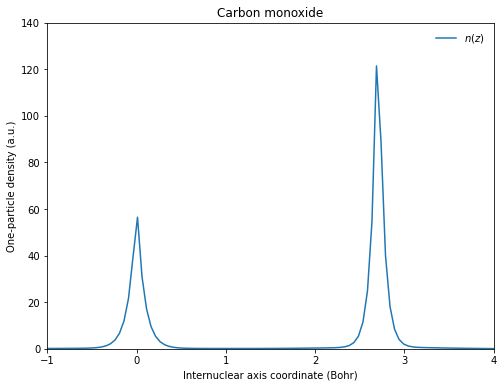

In [13]:
fig = plt.figure(1, figsize=(8,6))

plt.plot(z, one_part_den)

plt.axhline(y=0.0, color='0.5', linewidth = 0.7, dashes = [3,1,3,1])
plt.setp(plt.gca(), xlim = (-1,4), ylim = (0,140))
plt.legend([r'$n(z)$'], loc = 'upper right', frameon = False)

plt.title(r'Carbon monoxide')
plt.xlabel(r'Internuclear axis coordinate (Bohr)')
plt.ylabel(r'One-particle density (a.u.)')

plt.show()

## Two-particle density
The one-particle density can be written as an expectation of a two-electron operator according to

$$
n(\mathbf{r}, \mathbf{r}') =
\langle \Psi | \hat{n}(\mathbf{r}, \mathbf{r}') | \Psi \rangle
$$

with

$$
\hat{n}(\mathbf{r}, \mathbf{r}') = 
\sum_{j>i}^N \left[
\delta(\mathbf{r} - \mathbf{r}_i) \delta(\mathbf{r}' - \mathbf{r}_j)
+
\delta(\mathbf{r} - \mathbf{r}_j) \delta(\mathbf{r}' - \mathbf{r}_i)
\right]
$$

For an $N$-electron system in a state described by a Slater determinant, the two-electron density becomes

$$
n(\mathbf{r}_1, \mathbf{r}_2)
= \sum_{i=1}^N
\sum_{j=1}^N 
\left[\rule{0pt}{12pt}
|\psi_i(\mathbf{r}_1)|^2
|\psi_j(\mathbf{r}_2)|^2
-
\psi_i^\dagger(\mathbf{r}_1)
\psi_j^\dagger(\mathbf{r}_2)
\psi_j(\mathbf{r}_1)
\psi_i(\mathbf{r}_2)
\right]
$$

where the summations run over the $N$ occupied spin orbitals.


## Illustration of electron correlation

### Hartree--Fock state for hydrogen molecule

In [3]:
mol_str = """
H     0.000000    0.000000   -0.7
H     0.000000    0.000000    0.7
"""
molecule = vlx.Molecule.read_str(mol_str, units='au')
basis = vlx.MolecularBasis.read(molecule, 'sto-3g')

scf_drv = vlx.ScfRestrictedDriver()
scf_drv.compute(molecule, basis)

                                                                                                                          
                                            Self Consistent Field Driver Setup                                            
                                                                                                                          
                   Wave Function Model             : Spin-Restricted Hartree-Fock                                         
                   Initial Guess Model             : Superposition of Atomic Densities                                    
                   Convergence Accelerator         : Two Level Direct Inversion of Iterative Subspace                     
                   Max. Number of Iterations       : 50                                                                   
                   Max. Number of Error Vectors    : 10                                                                   
                

In [3]:
V_nrep = molecule.nuclear_repulsion_energy()
C = scf_drv.scf_tensors['C']

norb = C.shape[0]
print('Number of orbitals:', norb)

Number of orbitals: 2


### One- and two-electron integrals

In [4]:
kin_drv = vlx.KineticEnergyIntegralsDriver()
T_ao = kin_drv.compute(molecule, basis).to_numpy()
T = np.einsum('ai, ab, bj', C, T_ao, C)

npot_drv = vlx.NuclearPotentialIntegralsDriver()
V_ao = -npot_drv.compute(molecule, basis).to_numpy()
V = np.einsum('ai, ab, bj', C, V_ao, C)

# core Hamiltonian
h = T + V

eri_drv = vlx.ElectronRepulsionIntegralsDriver()
eri_ao = np.zeros((norb, norb, norb, norb))
eri_drv.compute_in_mem(molecule, basis, eri_ao)
g = np.zeros((norb, norb, norb, norb))
g = np.einsum('abcd,ai,bj,ck,dl', eri_ao, C, C, C, C)

print('T =\n', T)
print('V =\n', V)
print('h =\n', h)

print('(11|11) = %6.4f' % g[0,0,0,0])
print('(22|22) = %6.4f' % g[1,1,1,1])
print('(11|22) = %6.4f' % g[0,0,1,1])
print('(12|12) = %6.4f\n' % g[0,1,0,1])

print(f'Kinetic energy (a.u.): {2 * T[0,0]: .6f}')
print(f'Electronic-nuclear potential energy (a.u.): {2 * V[0,0]: .6f}')
print(f'Electron-electron repulsion energy (a.u.): {g[0,0,0,0]: .6f}')
print(f'Nuclear repulsion energy (a.u.): {V_nrep: .6f}')
print(f'HF energy (a.u.): {2 * h[0,0] + g[0,0,0,0] + V_nrep: .6f}')

T =
 [[0.60053975 0.        ]
 [0.         1.53685121]]
V =
 [[-1.85333681e+00  0.00000000e+00]
 [ 2.22044605e-16 -2.01245351e+00]]
h =
 [[-1.25279706e+00  0.00000000e+00]
 [ 2.22044605e-16 -4.75602299e-01]]
(11|11) = 0.6746
(22|22) = 0.6975
(11|22) = 0.6636
(12|12) = 0.1813

Kinetic energy (a.u.):  1.201079
Electronic-nuclear potential energy (a.u.): -3.706674
Electron-electron repulsion energy (a.u.):  0.674594
Nuclear repulsion energy (a.u.):  0.714286
HF energy (a.u.): -1.116714


### CI doubles state

In [5]:
H_CID = np.zeros((2,2))

H_CID[0,0] = 2*h[0,0] + g[0,0,0,0]
H_CID[1,1] = 2*h[1,1] + g[1,1,1,1]
H_CID[0,1] = g[0,1,0,1]
H_CID[1,0] = H_CID[0,1]

# diagonalize the CID Hamiltonian
E_CID, V_CID = np.linalg.eigh(H_CID)
#print('CID energies = \n', E_CID)
#print('CID vectors =\n', V_CID)

c_HF = V_CID[0,0]
c_uu = V_CID[1,0]

print(f'Hartree–Fock energy = {H_CID[0,0] + V_nrep : .6f} (a.u.)')
print(f'Correlation energy = {E_CID[0] - H_CID[0,0] : .6f} (a.u.)')
print(f'Total CID energy = {E_CID[0] + V_nrep : .6f} (a.u.)')
print(f'Weights (percent): {c_HF**2*100 : .2f} {c_uu**2*100 : .2f}')

Hartree–Fock energy = -1.116714 (a.u.)
Correlation energy = -0.020562 (a.u.)
Total CID energy = -1.137276 (a.u.)
Weights (percent):  98.73  1.27


### Visiualization of densities

In [6]:
# visualization
vis_drv = vlx.VisualizationDriver()

#### One-electron density
The CID state equals
$$
| \Psi \rangle =  c_0 | \Psi_\mathrm{HF} \rangle + c_1 | \Psi_{u\bar{u}} \rangle
$$

For a real-valued wave function, we get
$$
n(\mathbf{r}, \mathbf{r}') = 
c_0^2 \langle \Psi_\mathrm{HF} | \hat{n} | \Psi_\mathrm{HF} \rangle
+
c_1^2 \langle \Psi_{u\bar{u}} | \hat{n} | \Psi_{u\bar{u}} \rangle
+
2 c_0 c_1 \langle \Psi_\mathrm{HF} | \hat{n} | \Psi_{u\bar{u}} \rangle
$$

The general relations for matrix elements of a one-electron operator can now be used
\begin{align*}
    \langle \Psi | \hat{\Omega} | \Psi \rangle &=
   \sum_{i=1}^N
    \langle i| \hat{\omega} |i \rangle
    \\
    \langle \Psi | \hat{\Omega} | \Psi_{ij}^{st} \rangle &= 0
\end{align*}

In our case, we get
$$
\langle \Psi_\mathrm{HF} | \hat{\Omega} | \Psi_\mathrm{HF} \rangle =
2 (g| \hat{\omega} |g)
$$
$$
\langle \Psi_{u\bar{u}} | \hat{\Omega}| \Psi_{u\bar{u}} \rangle =
2 (u| \hat{\omega} |u)
$$
$$
\langle \Psi_\mathrm{HF} | \hat{\Omega} | \Psi_{u\bar{u}} \rangle = 0
$$

In [7]:
# mo values at given coordinates
mol_orbs = scf_drv.mol_orbs

n = 100
coords = np.zeros((n,3))
coords[:,2] = np.linspace(-3, 3, n, endpoint=True)

sigma_g = np.array(vis_drv.get_mo(coords, molecule, basis, mol_orbs, 0, 'alpha'))
sigma_u = np.array(vis_drv.get_mo(coords, molecule, basis, mol_orbs, 1, 'alpha'))

n1_HF = 2 * sigma_g**2
n1_CID = 2 * (c_HF**2 * sigma_g**2 + c_uu**2 * sigma_u**2)

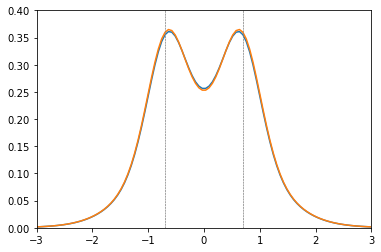

In [11]:
fig = plt.figure(1)
plt.axes()
plt.plot(coords[:,2], n1_HF)
plt.plot(coords[:,2], n1_CID)

Hz = vlx.Molecule.get_coordinates(molecule)[1,2] # z-coord of atom 2

plt.axvline(x=Hz, color='0.5', linewidth = 0.7, dashes = [3,1,3,1])
plt.axvline(x=-Hz, color='0.5', linewidth = 0.7, dashes = [3,1,3,1])
plt.setp(plt.gca(), xlim = (-3,3), ylim = (0,0.4))

plt.show()

#### Two-particle density
The CID state equals
$$
| \Psi \rangle =  c_0 | \Psi_\mathrm{HF} \rangle + c_1 | \Psi_{u\bar{u}} \rangle
$$

For a real-valued wave function, we get
$$
n(\mathbf{r}, \mathbf{r}') = 
c_0^2 \langle \Psi_\mathrm{HF} | \hat{n} | \Psi_\mathrm{HF} \rangle
+
c_1^2 \langle \Psi_{u\bar{u}} | \hat{n} | \Psi_{u\bar{u}} \rangle
+
2 c_0 c_1 \langle \Psi_\mathrm{HF} | \hat{n} | \Psi_{u\bar{u}} \rangle
$$

The general relations for matrix elements of a two-electron operator can now be used
\begin{align*}
    \langle \Psi | \hat{\Omega} | \Psi \rangle &=
    \frac{1}{2} \sum_{i,j}^N
    \Big[
    \langle ij| \hat{\omega} |ij \rangle - \langle ij | \hat{\omega} | ji \rangle
    \Big]
    \\
    \langle \Psi | \hat{\Omega} | \Psi_{ij}^{st} \rangle &=
     \langle ij| \hat{\omega} |st \rangle - \langle ij| \hat{\omega} |ts \rangle
\end{align*}

In our case, we get
$$
\langle \Psi_\mathrm{HF} | \hat{\Omega} | \Psi_\mathrm{HF} \rangle =
(gg| \hat{\omega} |gg)
$$
$$
\langle \Psi_{u\bar{u}} | \hat{\Omega}| \Psi_{u\bar{u}} \rangle =
(uu| \hat{\omega} |uu)
$$
$$
\langle \Psi_\mathrm{HF} | \hat{\Omega} | \Psi_{u\bar{u}} \rangle =
(gu| \hat{\omega} |gu)
$$

In [9]:
# electron 1 at the position of the hydrogen nucleus
# electron 2 anywhere on the internuclear axis
h1 = [[0, 0, Hz]]
sigma_g_at_h1 = vis_drv.get_mo(h1, molecule, basis, mol_orbs, 0, 'alpha')[0]
sigma_u_at_h1 = vis_drv.get_mo(h1, molecule, basis, mol_orbs, 1, 'alpha')[0]

n12_HF = 2 * sigma_g_at_h1**2 * sigma_g**2
n12_CID = 2 * (c_HF**2 * sigma_g_at_h1**2 * sigma_g**2 + 
               c_uu**2 * sigma_u_at_h1**2 * sigma_u**2 +
              2 * c_HF * c_uu * sigma_g_at_h1 * sigma_u_at_h1 *
              sigma_g * sigma_u)

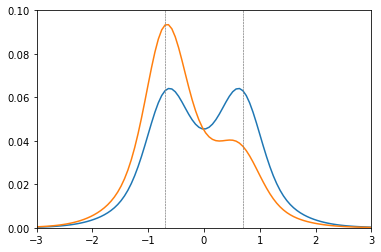

In [12]:
fig = plt.figure(2)
plt.axes()
plt.plot(coords[:,2], n12_HF)
plt.plot(coords[:,2], n12_CID)

plt.axvline(x=Hz, color='0.5', linewidth = 0.7, dashes = [3,1,3,1])
plt.axvline(x=-Hz, color='0.5', linewidth = 0.7, dashes = [3,1,3,1])
plt.setp(plt.gca(), xlim = (-3,3), ylim = (0,0.1))

plt.show()